## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('../../../data/clean/btc_high.csv')
df.pop('volume')
df.pop('low')
df.pop('open')
df.pop('close')
df.pop('adjclose')
df = df.reset_index()
df['formatted_date'] = pd.to_datetime(df['formatted_date']).values.astype(np.int64)
df.set_index("formatted_date",inplace=True)
df.pop('index')
df.pop('Unnamed: 0')
df_high = df['high'].values.reshape(-1, 1)

df

,high
formatted_date,
1546300800000000000,3947.981201
1546387200000000000,3935.685059
1546473600000000000,3865.934570
1546560000000000000,3904.903076
1546646400000000000,4093.297363
...,...
1681948800000000000,28349.968750
1682035200000000000,27872.142578
1682121600000000000,27820.244141


# Chuẩn hóa dữ liệu

In [3]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['high'] = arima_sc.fit_transform(df_high)
df_scaled

,high
formatted_date,
1546300800000000000,-1.161881
1546387200000000000,-1.162588
1546473600000000000,-1.166601
1546560000000000000,-1.164359
1546646400000000000,-1.153521
...,...
1681948800000000000,0.241920
1682035200000000000,0.214431
1682121600000000000,0.211446


# Vẽ đồ thị

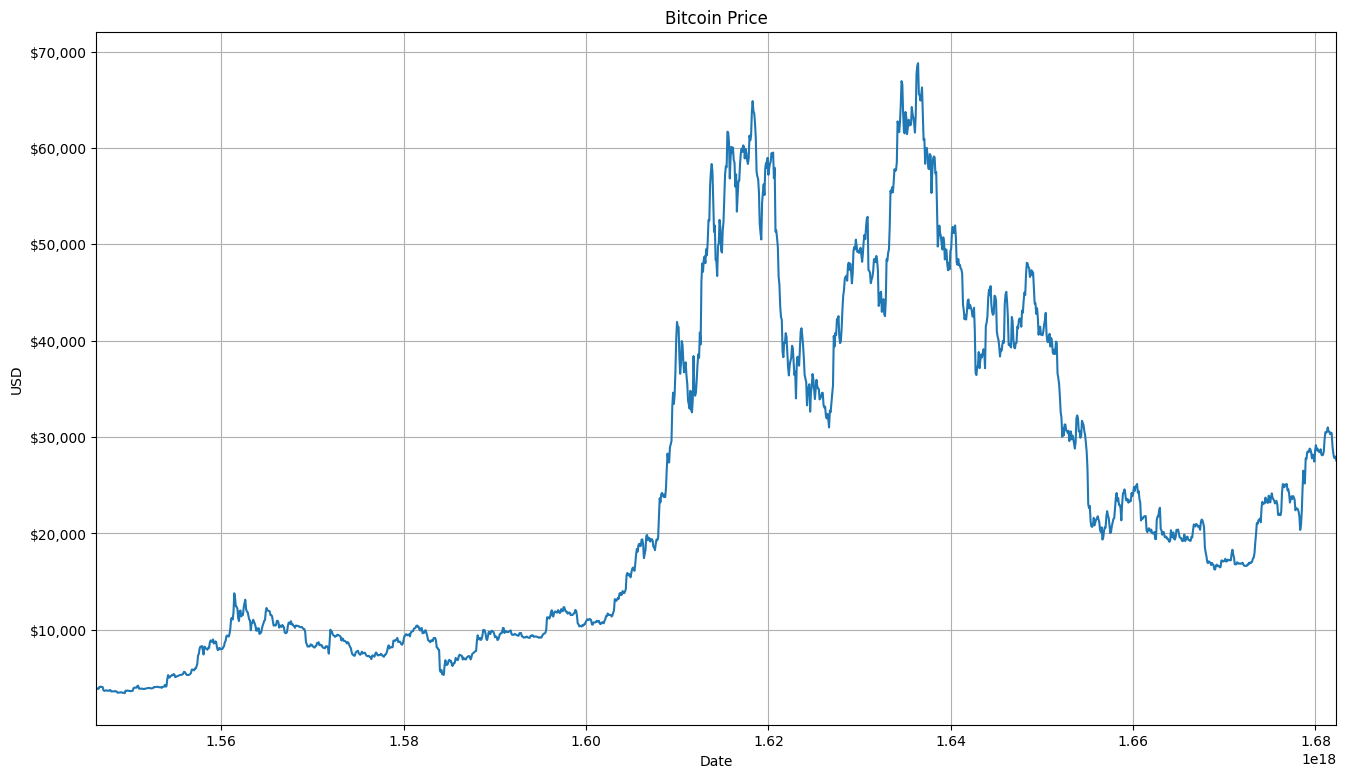

In [4]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['high'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [5]:
train, test = df_scaled[:(int)(len(df_scaled) * 1)], df_scaled[(int)(len(df_scaled) * 1):]
index_test = df_scaled.index[:(int)(len(df_scaled) * 1)]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (1575, 1)
test shape:  (0, 1)


# Hàm kiểm định chuỗi dừng

In [6]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [7]:
adf_test(train['high'],'Bitcoin Price')

Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic          -1.553096
p-value                      0.507102
Number of lags used          4.000000
Number of observations    1570.000000
critical value (1%)         -3.434522
critical value (5%)         -2.863383
critical value (10%)        -2.567751
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

<Axes: xlabel='formatted_date'>

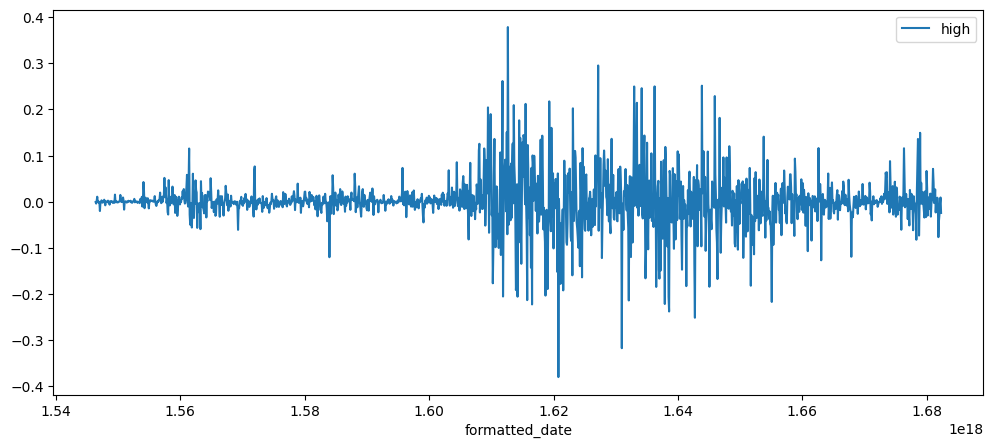

In [8]:
diff_1 = train.dropna().diff()
diff_1.plot(figsize=(12,5))

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [9]:
adf_test(diff_1, 'Bitcoin Price First Difference')

Augmented Dickey-Fuller Test: Bitcoin Price First Difference
ADF test statistic       -1.788300e+01
p-value                   2.997445e-30
Number of lags used       3.000000e+00
Number of observations    1.570000e+03
critical value (1%)      -3.434522e+00
critical value (5%)      -2.863383e+00
critical value (10%)     -2.567751e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [10]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [11]:
import pickle
arima_model = ArimaModel(train)
arima_model.summary()
with open("../../../models/high/arima_model.pkl", "wb") as f:
        pickle.dump(arima_model, f)
    

    
    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4709.282, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4694.364, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4715.176, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4714.548, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4695.968, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4713.222, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4713.219, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4711.234, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4716.867, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4714.916, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4714.913, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4716.228, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4712.928, Time=0.25 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.025 seconds


# Dự đoán trên tập test

In [12]:
pred = arima_model.predict(len(train))
pred


1575    0.193419
1576    0.193067
1577    0.193025
1578    0.193020
1579    0.193019
          ...   
3145    0.193019
3146    0.193019
3147    0.193019
3148    0.193019
3149    0.193019
Length: 1575, dtype: float64

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [13]:
inv_test = arima_sc.inverse_transform(train.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

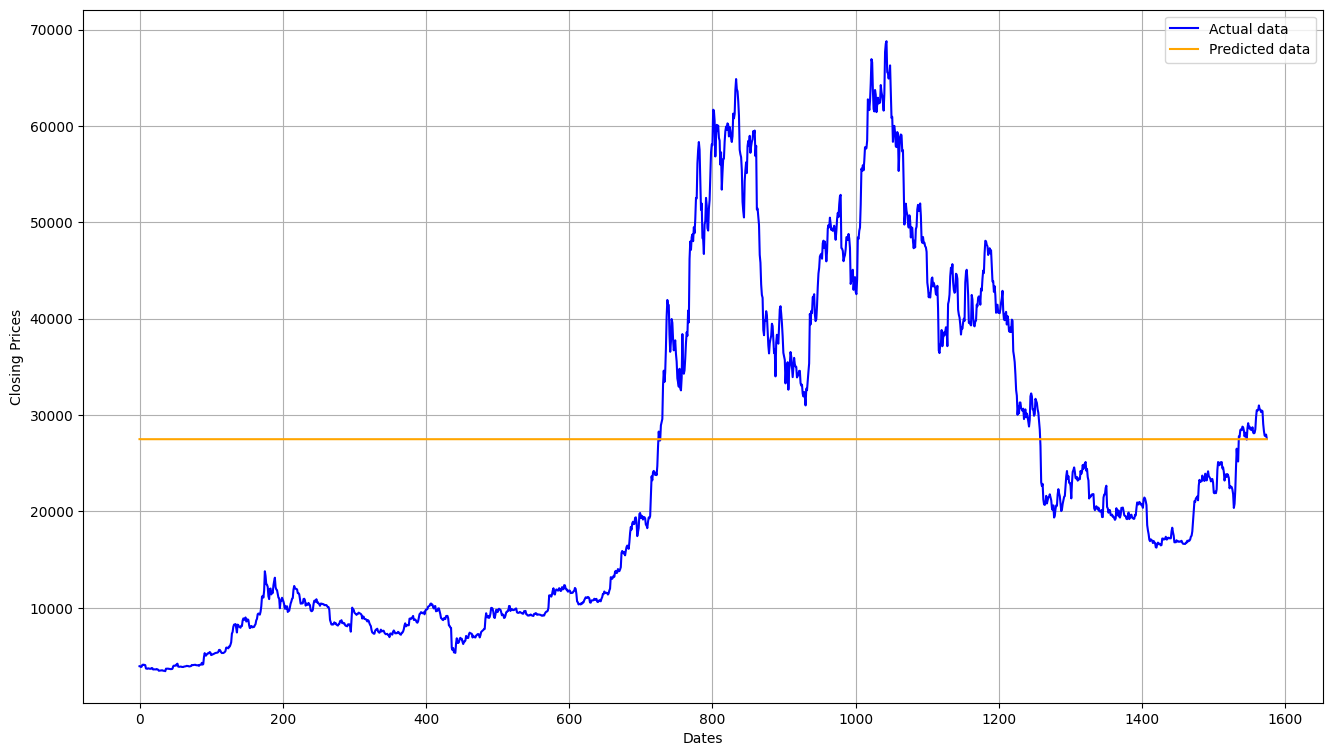

In [14]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [15]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 15775.25
MAPE: 133.96%
MSE: 313419522.86
RMSE: 17703.66
R2: -0.04


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [16]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
formatted_date,,,
1546300800000000000,3947.981201,27506.882207,-23558.901006
1546387200000000000,3935.685059,27500.777913,-23565.092854
1546473600000000000,3865.934570,27500.044026,-23634.109455
1546560000000000000,3904.903076,27499.955794,-23595.052718
1546646400000000000,4093.297363,27499.945187,-23406.647824
...,...,...,...
1681948800000000000,28349.968750,27499.943737,850.025013
1682035200000000000,27872.142578,27499.943737,372.198841
1682121600000000000,27820.244141,27499.943737,320.300403


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [17]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
formatted_date,,,
1546300800000000000,3947.981201,27506.882207,-23558.901006
1546387200000000000,3935.685059,27500.777913,-23565.092854
1546473600000000000,3865.934570,27500.044026,-23634.109455
1546560000000000000,3904.903076,27499.955794,-23595.052718
1546646400000000000,4093.297363,27499.945187,-23406.647824
...,...,...,...
1681948800000000000,28349.968750,27499.943737,850.025013
1682035200000000000,27872.142578,27499.943737,372.198841
1682121600000000000,27820.244141,27499.943737,320.300403


# Vẽ đồ thị thể hiện sai số

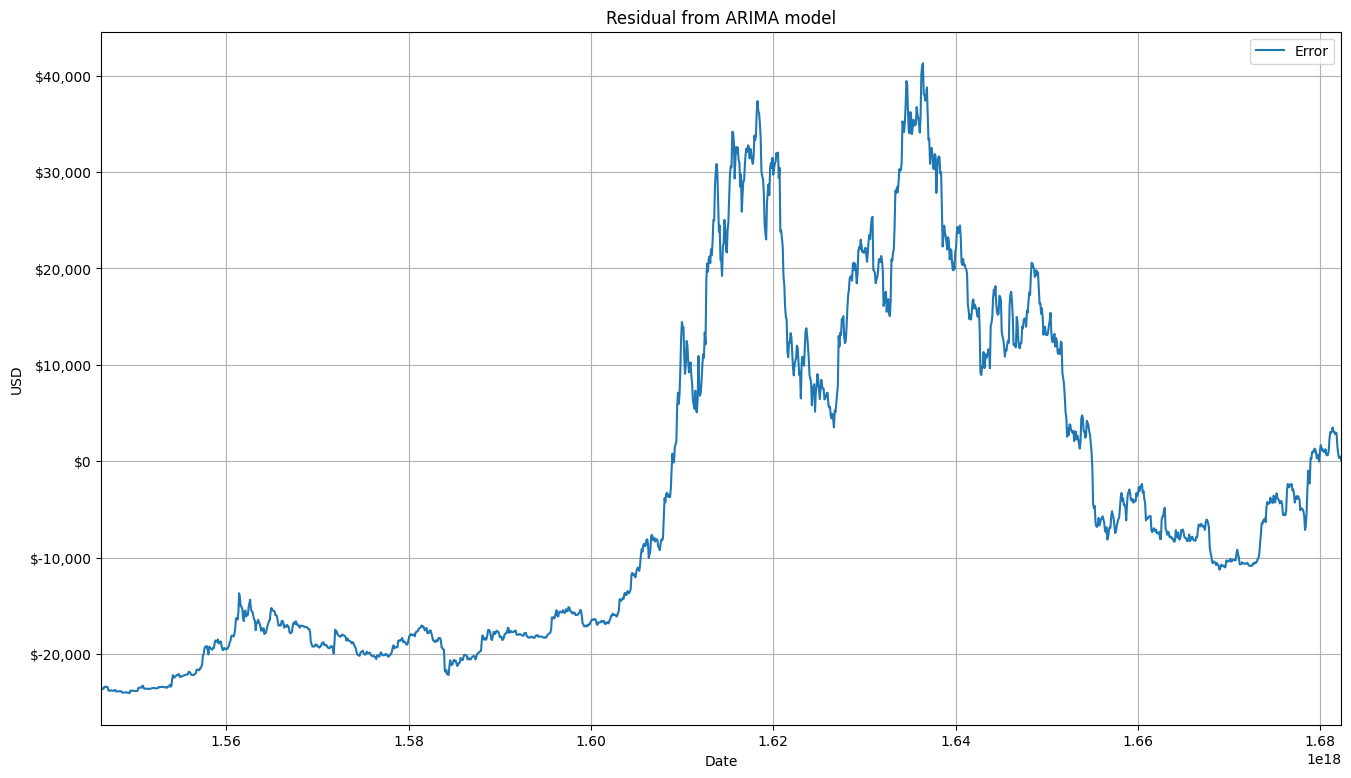

In [18]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [19]:
error = np.array(error)
error

array([[-23558.90100632],
       [-23565.09285424],
       [-23634.10945545],
       ...,
       [   320.30040338],
       [   480.03868463],
       [    57.71251276]])

In [20]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (1572, 3, 1)
y_train (1572, 1)


In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("../../../models/high/lstm.h5")

Epoch 1/300
50/50 [==============================] - 2s 3ms/step - loss: 271908480.0000
Epoch 2/300
50/50 [==============================] - 0s 2ms/step - loss: 74424432.0000
Epoch 3/300
50/50 [==============================] - 0s 2ms/step - loss: 7013696.0000
Epoch 4/300
50/50 [==============================] - 0s 3ms/step - loss: 2130006.7500
Epoch 5/300
50/50 [==============================] - 0s 2ms/step - loss: 2670746.7500
Epoch 6/300
50/50 [==============================] - 0s 2ms/step - loss: 2006544.0000
Epoch 7/300
50/50 [==============================] - 0s 3ms/step - loss: 1940818.3750
Epoch 8/300
50/50 [==============================] - 0s 2ms/step - loss: 1798223.7500
Epoch 9/300
50/50 [==============================] - 0s 2ms/step - loss: 1991697.1250
Epoch 10/300
50/50 [==============================] - 0s 2ms/step - loss: 2041839.5000
Epoch 11/300
50/50 [==============================] - 0s 2ms/step - loss: 2431748.2500
Epoch 12/300
50/50 [=============================

In [22]:
model = load_model("../../../models/high/lstm.h5")
error_pred = model.predict(x_train)
error_pred

50/50 [==============================] - 0s 2ms/step


array([[-23889.912  ],
       [-23814.42   ],
       [-23605.025  ],
       ...,
       [   405.1895 ],
       [   290.51297],
       [   499.83655]], dtype=float32)

In [23]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
formatted_date,,,,
1546300800000000000,3947.981201,27506.882207,-23558.901006,-23889.912109
1546387200000000000,3935.685059,27500.777913,-23565.092854,-23814.419922
1546473600000000000,3865.934570,27500.044026,-23634.109455,-23605.025391
1546560000000000000,3904.903076,27499.955794,-23595.052718,-23674.982422
1546646400000000000,4093.297363,27499.945187,-23406.647824,-23624.458984
...,...,...,...,...
1681689600000000000,30470.302734,27499.943737,2970.358997,1678.496216
1681776000000000000,30411.054688,27499.943737,2911.110950,882.758301
1681862400000000000,29076.400391,27499.943737,1576.456653,405.189514


In [24]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
formatted_date,,,,,
1546300800000000000,3947.981201,27506.882207,-23558.901006,-23889.912109,3616.970098
1546387200000000000,3935.685059,27500.777913,-23565.092854,-23814.419922,3686.357991
1546473600000000000,3865.934570,27500.044026,-23634.109455,-23605.025391,3895.018635
1546560000000000000,3904.903076,27499.955794,-23595.052718,-23674.982422,3824.973373
1546646400000000000,4093.297363,27499.945187,-23406.647824,-23624.458984,3875.486202
...,...,...,...,...,...
1681689600000000000,30470.302734,27499.943737,2970.358997,1678.496216,29178.439953
1681776000000000000,30411.054688,27499.943737,2911.110950,882.758301,28382.702038
1681862400000000000,29076.400391,27499.943737,1576.456653,405.189514,27905.133251


# Vẽ đồ thị

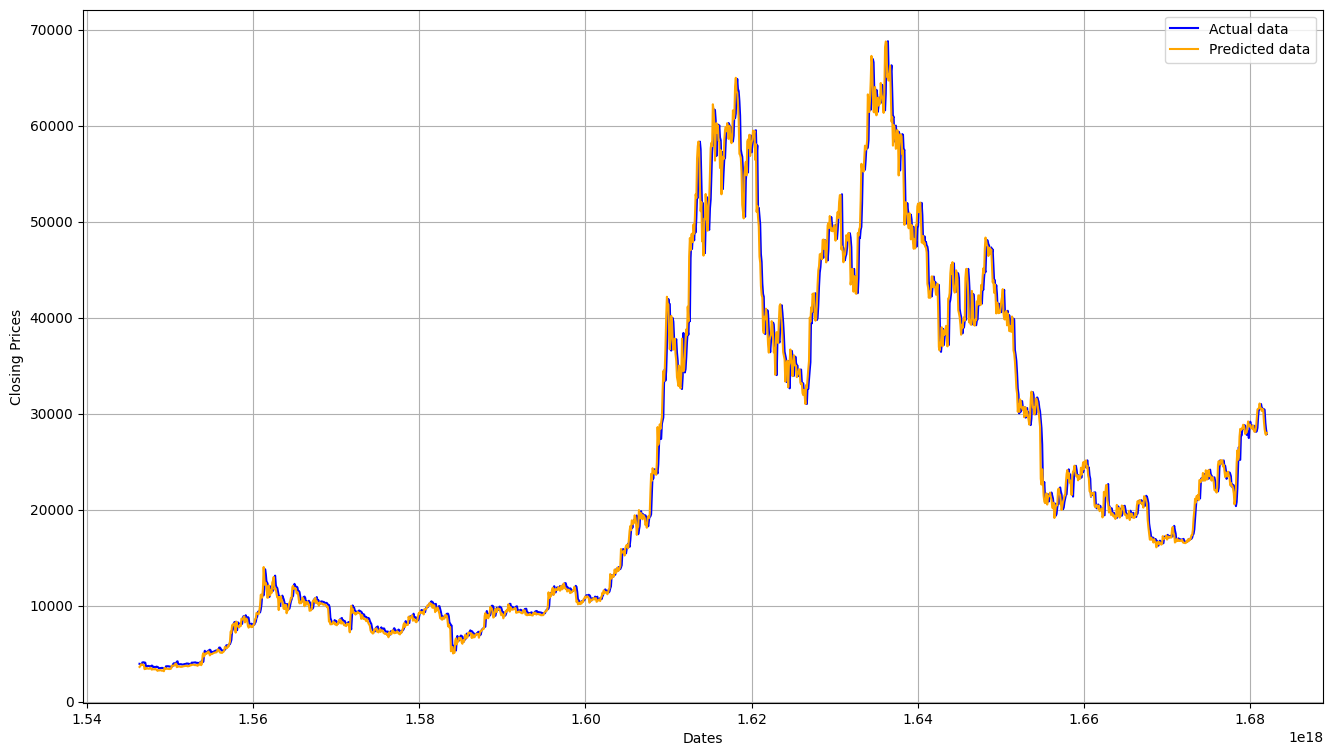

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [26]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 909.72
MAPE: 3.92%
MSE: 2200233.57
RMSE: 1483.32
R2: 0.99
